In [ ]:
# default_exp plot

# GraphPed

> A pedigree visualization tool based on dot format and visualized by graphviz 

In [ ]:
#hide
from nbdev.showdoc import *

https://h1ros.github.io/posts/introduction-to-graphviz-in-jupyter-notebook/

In [ ]:
#export
def GraphPedCli():
    import argparse
    parser = argparse.ArgumentParser(description="Just an example",
                                     formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument("-p", "--ped", help="ped file")
    parser.add_argument("-o", "--output", help="output folder")
    args = parser.parse_args()
    print(args)

def GraphPed(ped,output,fmt,attr):
    pass

In [ ]:
#export
from graphviz import Digraph
def update_attributes(r):
    attributes={'shape':'polygon','height':'0.3','width':'0.5','regular':'0','style':"filled,setlinewidth(4)",'fontcolor':'black'}
    gender = {"m":"box","1":"box",1:"box","f":"ellipse","2":"ellipse",2:"ellipse",0:"polygon"}
    trait = {1:'white',2:'dimgrey',-9:'aquamarine3'}
    vcf = {True:"filled,setlinewidth(4)",False:"filled"}
    trim = {True:'darkorange',False:'black'}
    attributes['shape'] = gender[r.sex]
    attributes['fillcolor']=trait[r.ad]
    attributes['style']=vcf[r.vcf]
    try:
        attributes['fontcolor'] = trim[r.trim]
    except:
        pass
    return attributes

def plotped(fi,output=False,folder='',format='svg'):
    #nodes
    #create iid nodes
    #create parent nodes
    #edges
    #parent to iid
    #fathid,mothid to parent
    # Create Digraph object
    dot = Digraph()
    # Add nodes
    parents = []
    for i,r in fi.iterrows():
        dot.node(r.iid,shape='box',_attributes=update_attributes(r))
        if r.fathid !='0' and r.mothid !='0':
            parents.append(r.fathid+'x'+r.mothid)
            dot.edge(r.fathid+'x'+r.mothid,r.iid)
        #edge to children
        ch_r = (fi.fathid==r.iid) | (fi.mothid==r.iid)
        if ch_r.any():
            for p in fi[ch_r][['fathid','mothid']].agg('x'.join, axis=1).unique():
                dot.edge(r.iid,p)
    for p in set(parents):
        dot.node(p,shape='diamond',label='',height='.1',width='.1')
    if output:
        dot.render(outfile=folder+'/ADfam_'+str(list(fi.fid)[0])+'.'+format,format=format,overwrite_source=True)
    return dot

In [ ]:
import pandas as pd

In [ ]:
ped = pd.read_csv('data/nodp_ped_with_depth_trim.csv',header=0,index_col=None)

In [ ]:
new_twom_fam = pd.read_csv('data/new_twoormore_member_fam.csv',header=None,names=['fid','iid','fathid','mothid','sex','ad','vcf'])

In [ ]:
new_twom_fam

,fid,iid,fathid,mothid,sex,ad,vcf
0,4_364,4_364_99,4_364_1,4_364_2,2,2,True
1,4_44,4_44_3,4_44_1,4_44_2,2,2,True
2,27_104,27_104_62571,27_104_84753,27_104_84752,1,2,True
3,27_90,27_90_84583,27_90_84575,27_90_84574,2,2,True
4,27_90,27_90_84784,27_90_84575,27_90_84574,2,2,True
...,...,...,...,...,...,...,...
19101,27_119,27_119_86892,0,0,2,-9,False
19102,27_192,27_192_86089,0,0,2,-9,False
19103,10R_R1,10R_R1_20,0,0,2,-9,False
19104,10R_R57,10R_R57_R15,0,0,2,-9,False


In [ ]:
fi = ped[ped.fid =='997']

In [ ]:
[plotped(new_twom_fam[new_twom_fam.fid ==i],output=True,folder='data/',format='pdf') for i in ['4_364','27_104','4_461','215','10R_R99']]

In [ ]:
new_twom_fam[new_twom_fam.fid =='10R_R99']

,fid,iid,fathid,mothid,sex,ad,vcf
754,10R_R99,10R_R99_15,10R_R99_8,10R_R99_7,2,2,True
759,10R_R99,10R_R99_12,10R_R99_8,10R_R99_7,2,2,True
762,10R_R99,10R_R99_1,10R_R99_8,10R_R99_7,2,2,True
763,10R_R99,10R_R99_5,10R_R99_8,10R_R99_7,1,1,True
764,10R_R99,10R_R99_6,10R_R99_8,10R_R99_7,2,1,True
765,10R_R99,10R_R99_10,10R_R99_2,10R_R99_1,2,1,True
766,10R_R99,10R_R99_17,10R_R99_29,10R_R99_15,1,1,True
767,10R_R99,10R_R99_19,10R_R99_2,10R_R99_1,1,1,True
14360,10R_R99,10R_R99_2,0,0,1,-9,False
14361,10R_R99,10R_R99_20,10R_R99_2,10R_R99_1,1,1,False


In [ ]:
dot=plotped(new_twom_fam[new_twom_fam.fid =='10R_R99'],output=True,folder='data/',format='pdf')

In [ ]:
print(dot.source)

digraph {
	"10R_R99_15" [shape=box fillcolor=dimgrey fontcolor=black height=0.3 regular=0 shape=ellipse style="filled,setlinewidth(4)" width=0.5]
	"10R_R99_8x10R_R99_7" -> "10R_R99_15"
	"10R_R99_15" -> "10R_R99_29x10R_R99_15"
	"10R_R99_12" [shape=box fillcolor=dimgrey fontcolor=black height=0.3 regular=0 shape=ellipse style="filled,setlinewidth(4)" width=0.5]
	"10R_R99_8x10R_R99_7" -> "10R_R99_12"
	"10R_R99_1" [shape=box fillcolor=dimgrey fontcolor=black height=0.3 regular=0 shape=ellipse style="filled,setlinewidth(4)" width=0.5]
	"10R_R99_8x10R_R99_7" -> "10R_R99_1"
	"10R_R99_1" -> "10R_R99_2x10R_R99_1"
	"10R_R99_5" [shape=box fillcolor=white fontcolor=black height=0.3 regular=0 shape=box style="filled,setlinewidth(4)" width=0.5]
	"10R_R99_8x10R_R99_7" -> "10R_R99_5"
	"10R_R99_5" -> "10R_R99_19x10R_R99_5"
	"10R_R99_6" [shape=box fillcolor=white fontcolor=black height=0.3 regular=0 shape=ellipse style="filled,setlinewidth(4)" width=0.5]
	"10R_R99_8x10R_R99_7" -> "10R_R99_6"
	"10R_R99_1

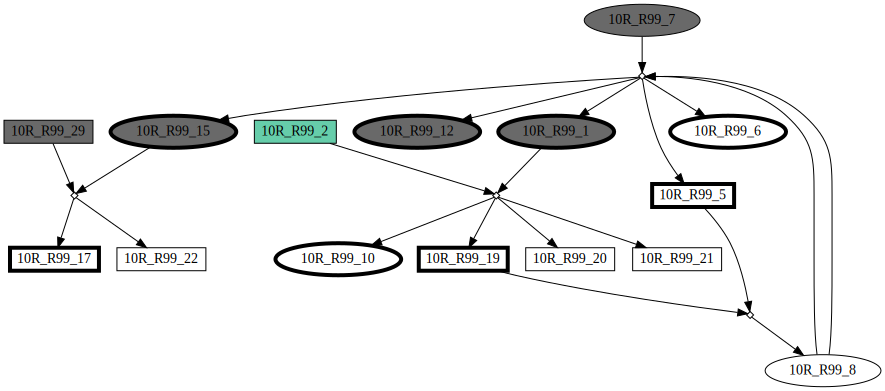

In [ ]:
dot

## Output plot

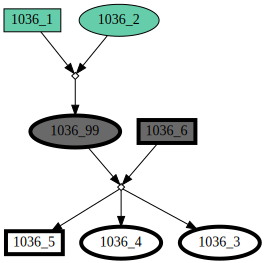

In [ ]:
plotped(ped[ped.fid =='1036'])

In [ ]:
trim_ped = ped[ped.trim==False]

array([[<AxesSubplot:title={'center':'before'}>,
        <AxesSubplot:title={'center':'after'}>]], dtype=object)

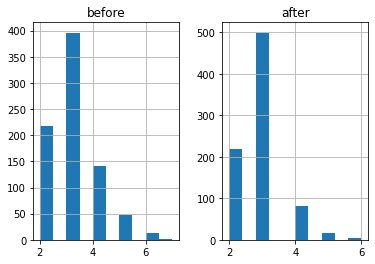

In [ ]:
trim_smry = pd.DataFrame([[ped.depth[ped.fid == i].max() for i in trim_ped.fid.unique()],[trim_ped.depth[trim_ped.fid == i].max() for i in trim_ped.fid.unique()]])
trim_smry = trim_smry.T
trim_smry.index = trim_ped.fid.unique()
trim_smry.columns = ['before','after']
trim_smry.hist()

In [ ]:
len(trim_smry.index[(trim_smry.before>3) & (trim_smry.after<4)])

103

In [ ]:
sum(trim_smry.before>4)

62

In [ ]:
sum(trim_smry.after<4)

717

In [ ]:
sum((tmp[0]<) & (tmp[1]<4))

0

In [ ]:
dots1 = [plotped(ped[ped.fid ==i],folder='data/ADfam_depthless4') for i in trim_smry.index[trim_smry.before<4]]

In [ ]:
dots2 = [plotped(ped[ped.fid ==i],folder='data/ADfam_trimless4/') for i in trim_smry.index[(trim_smry.before>3) & (trim_smry.after<4)]]

In [ ]:
dots3 = [plotped(ped[ped.fid ==i],folder='data/ADfam_trimmore4/') for i in trim_smry.index[trim_smry.after>3]]

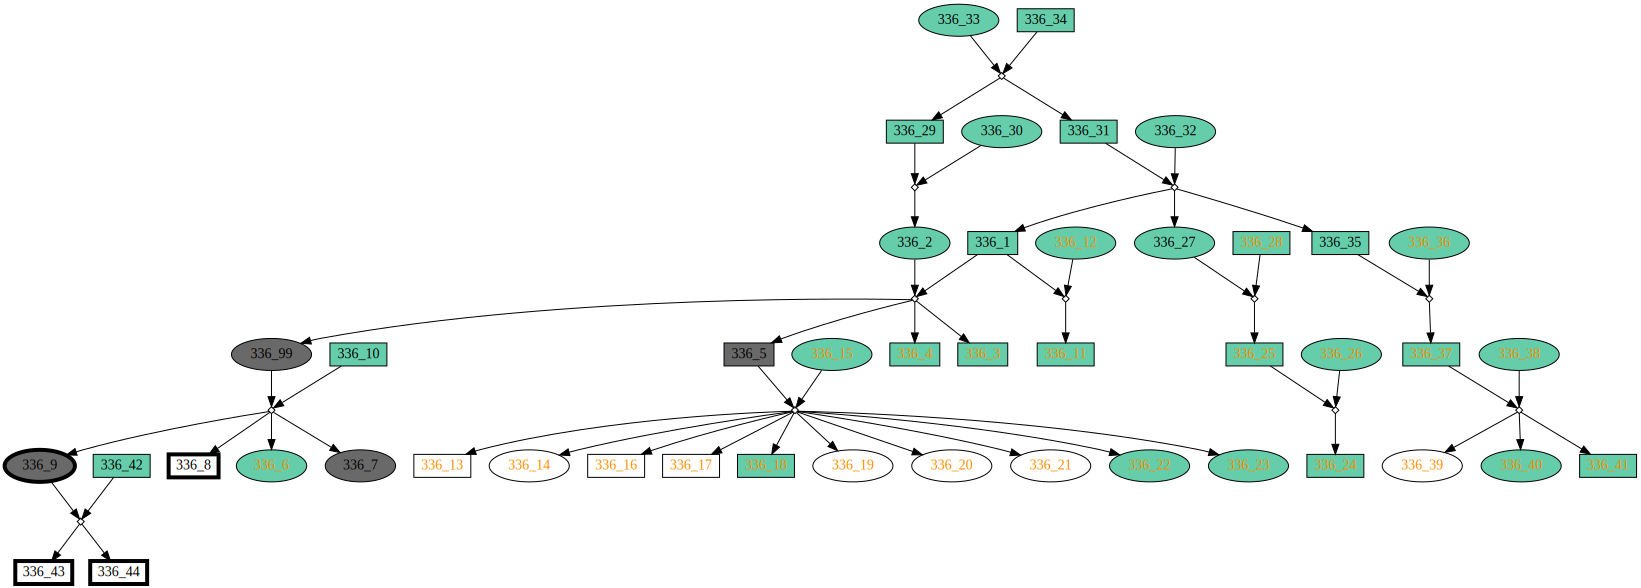

In [ ]:
plotped(ped[ped.fid =='336'])

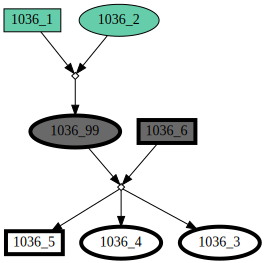

In [ ]:
dot